# Inversão não linear de dados de grav para estimar o relevo de uma bacia sedimentar

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import harmonica as hm
import bordado as bd

## Gerar dados sintéticos

In [2]:
def gaussiana(x, amplitude, deslocamento, desvio_padrao):
    return amplitude * np.exp(-((x-deslocamento)/desvio_padrao)**2)

def sintetico():
    n_prismas = 100
    x_min, x_max = 10e3, 90e3
    x = bd.line_coordinates(x_min, x_max, size=n_prismas, pixel_register=True)
    profundidades = (
        gaussiana(x, amplitude=5e3, deslocamento=40e3, desvio_padrao=20e3)
        + gaussiana(x, amplitude=2e3, deslocamento=80e3, desvio_padrao=10e3)
        + gaussiana(x, amplitude=2e3, deslocamento=30e3, desvio_padrao=10e3)
    )
    profundidades -= profundidades.min()
    return profundidades, x_min, x_max

def plota_prismas(profundidades, x_min, x_max):
    bordas = bd.line_coordinates(x_min, x_max, size=profundidades.size+1)
    x = [x_min]
    y = [0]
    for i in range(profundidades.size):
        x.extend([bordas[i], bordas[i+1]])
        y.extend([profundidades[i], profundidades[i]])
    x.append(x_max)
    y.append(0)

    fig, ax = plt.subplots(1,1)
    ax.set_xlabel("x[m]")
    ax.set_ylabel("profundidade[m]")
    ax.set_ylim(np.max(profundidades)*1.05, 0)
    ax.plot(x,y)

    return ax

<Axes: xlabel='x[m]', ylabel='profundidade[m]'>

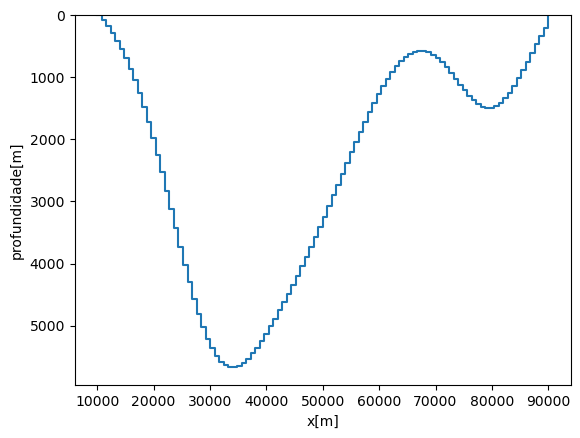

In [3]:
profundidades, x_min, x_max = sintetico()
plota_prismas(profundidades, x_min, x_max)